In [ ]:
import os
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:

def load_data(data_dir):
    X = []
    y = []
    for class_label, class_name in enumerate(['CleanData_IDD/Music', 'CleanData_TDC/Music']):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.mat'):
                file_path = os.path.join(class_dir, filename)
                data = loadmat(file_path)
                # file .mat có key là 'data'
                signal = data['clean_data']
                X.append(signal)
                y.append(class_label)
    return np.array(X), np.array(y)
data_dir = '/content/drive/MyDrive/Môn học ML/EEG_IDD_TDC/Data/CleanData/'
X, y = load_data(data_dir)

In [ ]:
X.shape

(14, 14, 15360)

In [ ]:
X  = np.transpose(X , (0, 2, 1))

In [ ]:
X.shape

(14, 15360, 14)

In [ ]:
# Hàm cắt đoạn
def segment_signal(X, segment_length):
    segments = []
    for sample in X:
        # Lấy số lượng đoạn con từ mỗi sample
        num_segments = len(sample) // segment_length
        for i in range(num_segments):
            segment = sample[i * segment_length:(i + 1) * segment_length, :]
            segments.append(segment)
    return np.array(segments)
segment_length = 256
# Cắt đoạn tập huấn luyện và tập kiểm tra
X_segments = segment_signal(X, segment_length)
y_segments = np.repeat(y, X_segments.shape[0] // y.shape[0], axis=0)


In [ ]:
X_segments.shape

(840, 256, 14)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_segments, y_segments, test_size=0.2,stratify=y_segments, random_state=42)

print(f'X_train_segments shape: {X_train.shape}')  # (số lượng đoạn, segment_length, số kênh)
print(f'X_test_segments shape: {X_test.shape}')    # (số lượng đoạn, segment_length, số kênh)

X_train_segments shape: (672, 256, 14)
X_test_segments shape: (168, 256, 14)


In [ ]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Chuyển đổi nhãn thành one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# Định nghĩa độ dài của segment muốn cắt



In [ ]:
y_train.shape

(672, 2)

In [ ]:

model2 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 14)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train , epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
21/21 [==============================] - 2s 37ms/step - loss: 0.5382 - accuracy: 0.7723 - val_loss: 0.0442 - val_accuracy: 0.9881
Epoch 2/30
21/21 [==============================] - 1s 26ms/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 3/30
21/21 [==============================] - 1s 27ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 4/30
21/21 [==============================] - 0s 24ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 5/30
21/21 [==============================] - 1s 29ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 6/30
21/21 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/30
21/21 [==============================] - 1s 27ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 8/30
21

In [ ]:
# kiểm tra phân bố dữ liệu khi chia train test

### LSTM

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_2 = Sequential([
    LSTM(64, input_shape=(segment_length, 14), return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Biên dịch mô hình
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sử dụng EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
history = model_2.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/30
21/21 [==============================] - 10s 321ms/step - loss: 0.6265 - accuracy: 0.6711 - val_loss: 0.4498 - val_accuracy: 0.8988
Epoch 2/30
21/21 [==============================] - 5s 228ms/step - loss: 0.1151 - accuracy: 0.9821 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 3/30
21/21 [==============================] - 5s 220ms/step - loss: 0.0127 - accuracy: 0.9985 - val_loss: 0.0264 - val_accuracy: 0.9940
Epoch 4/30
21/21 [==============================] - 8s 401ms/step - loss: 0.0298 - accuracy: 0.9955 - val_loss: 0.0417 - val_accuracy: 0.9940
Epoch 5/30
21/21 [==============================] - 8s 398ms/step - loss: 0.0137 - accuracy: 0.9985 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/30
21/21 [==============================] - 6s 295ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/30
21/21 [==============================] - 7s 334ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 8.6438e-04 - val_accuracy: 1.0000
E

## RNN

In [ ]:
from tensorflow.keras.layers import Dense, SimpleRNN
model_3 = Sequential([
    SimpleRNN(64, input_shape=(segment_length, 14), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Biên dịch mô hình
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sử dụng EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
history = model_3.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/30
21/21 [==============================] - 11s 278ms/step - loss: 0.9632 - accuracy: 0.5074 - val_loss: 0.7782 - val_accuracy: 0.4524
Epoch 2/30
21/21 [==============================] - 5s 250ms/step - loss: 0.8733 - accuracy: 0.5134 - val_loss: 0.7637 - val_accuracy: 0.4940
Epoch 3/30
21/21 [==============================] - 5s 259ms/step - loss: 0.8606 - accuracy: 0.5104 - val_loss: 0.7676 - val_accuracy: 0.5417
Epoch 4/30
21/21 [==============================] - 5s 217ms/step - loss: 0.8117 - accuracy: 0.5461 - val_loss: 0.7609 - val_accuracy: 0.5060
Epoch 5/30
21/21 [==============================] - 5s 251ms/step - loss: 0.8172 - accuracy: 0.5402 - val_loss: 0.7588 - val_accuracy: 0.4940
Epoch 6/30
21/21 [==============================] - 5s 225ms/step - loss: 0.7522 - accuracy: 0.5610 - val_loss: 0.7162 - val_accuracy: 0.5417
Epoch 7/30
21/21 [==============================] - 2s 100ms/step - loss: 0.7475 - accuracy: 0.5670 - val_loss: 0.6672 - val_accuracy: 0.6071
Epoch

6/6 [==============================] - 0s 27ms/step - loss: 0.1909 - accuracy: 0.9464
Loss: 0.19087359309196472
Accuracy: 0.9464285969734192


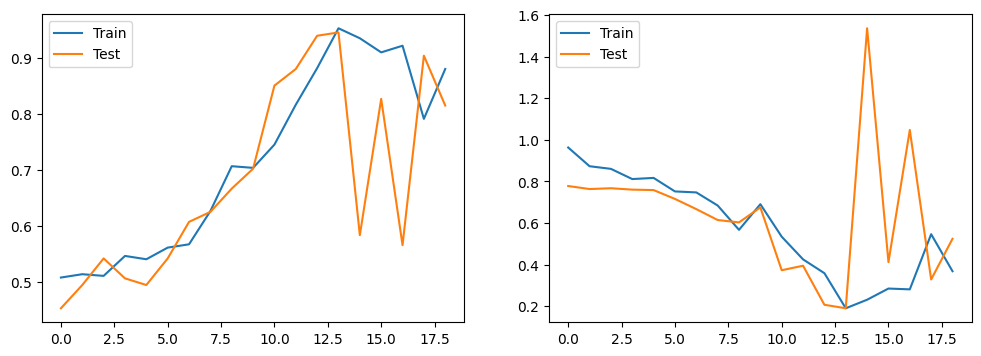

In [ ]:

loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
type(accuracy)

float

In [ ]:
history.history['accuracy']

[0.507440447807312,
 0.5133928656578064,
 0.5104166865348816,
 0.5461309552192688,
 0.5401785969734192,
 0.5610119104385376,
 0.5669642686843872,
 0.6264880895614624,
 0.706845223903656,
 0.7038690447807312,
 0.7455357313156128,
 0.8169642686843872,
 0.882440447807312,
 0.9538690447807312,
 0.9360119104385376,
 0.9107142686843872,
 0.9226190447807312,
 0.7916666865348816,
 0.8809523582458496]

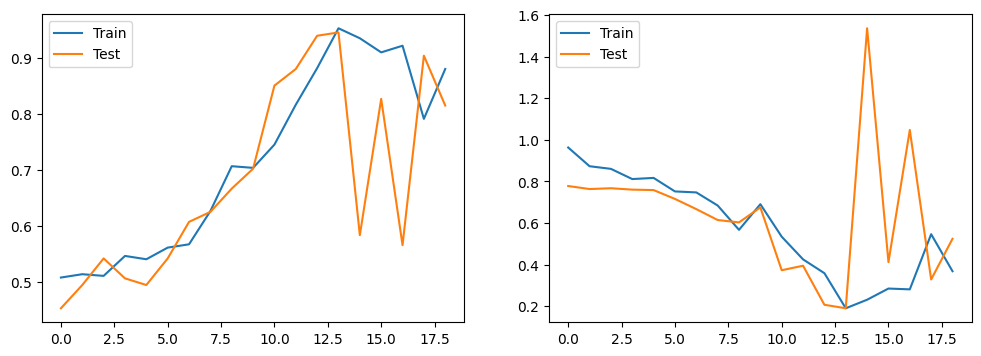

In [ ]:

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.legend(['Train', 'Test'], loc='upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

plot_history(history)


### More complex RNN

In [ ]:
model_4_x = Sequential([
    SimpleRNN(128, input_shape=(segment_length, 14), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(128, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(128),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Biên dịch mô hình
model_4_x.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Huấn luyện mô hình
history_4 = model_4_x.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test) )


Epoch 1/50
21/21 [==============================] - 11s 279ms/step - loss: 0.9098 - accuracy: 0.4985 - val_loss: 0.7135 - val_accuracy: 0.5179
Epoch 2/50
21/21 [==============================] - 7s 348ms/step - loss: 0.8375 - accuracy: 0.5312 - val_loss: 0.6816 - val_accuracy: 0.5536
Epoch 3/50
21/21 [==============================] - 5s 256ms/step - loss: 0.8199 - accuracy: 0.5402 - val_loss: 0.6031 - val_accuracy: 0.7321
Epoch 4/50
21/21 [==============================] - 11s 540ms/step - loss: 0.8452 - accuracy: 0.5179 - val_loss: 0.5774 - val_accuracy: 0.7083
Epoch 5/50
21/21 [==============================] - 6s 263ms/step - loss: 0.7956 - accuracy: 0.5432 - val_loss: 0.5986 - val_accuracy: 0.6726
Epoch 6/50
21/21 [==============================] - 7s 363ms/step - loss: 0.7869 - accuracy: 0.5476 - val_loss: 0.6141 - val_accuracy: 0.6548
Epoch 7/50
21/21 [==============================] - 5s 254ms/step - loss: 0.7598 - accuracy: 0.5565 - val_loss: 0.6059 - val_accuracy: 0.6964
Epoc

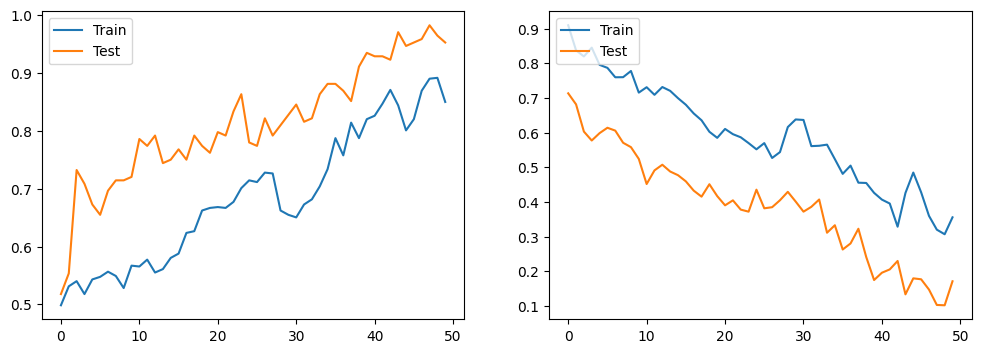

In [ ]:
plot_history(history_4)

### Augmentation

In [ ]:
# Hàm thêm nhiễu Gaussian vào tín hiệu
def add_gaussian_noise(signal, noise_level=0.01):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

# Hàm thay đổi cường độ tín hiệu
def scale_signal(signal, scaling_factor=1.1):
    return signal * scaling_factor

# Hàm dịch chuyển tín hiệu
def shift_signal(signal, shift):
    return np.roll(signal, shift, axis=0)

# Hàm cắt tín hiệu
def crop_signal(signal, crop_size):
    start = np.random.randint(0, signal.shape[0] - crop_size)
    return signal[start:start + crop_size, :]

# Hàm augment tín hiệu
def augment_signal(signal, augmentations):
    augmented_signals = [signal]
    for augmentation in augmentations:
        if augmentation == 'noise':
            augmented_signals.append(add_gaussian_noise(signal))
        elif augmentation == 'scaling':
            augmented_signals.append(scale_signal(signal))
        elif augmentation == 'shifting':
            shift = np.random.randint(-10, 10)
            augmented_signals.append(shift_signal(signal, shift))
        elif augmentation == 'cropping':
            crop_size = int(signal.shape[0] * 0.9)
            augmented_signals.append(crop_signal(signal, crop_size))
    return augmented_signals

In [ ]:
# Augment dữ liệu huấn luyện
augmentations = ['noise', 'scaling', 'shifting', 'cropping']
X_train_augmented = []
y_train_augmented = []

for i in range(len(X_train)):
    augmented_signals = augment_signal(X_train[i], augmentations)
    for augmented_signal in augmented_signals:
        # Pad shorter signals to match the longest one
        max_length = max([sig.shape[0] for sig in augmented_signals])
        augmented_signal = np.pad(augmented_signal, ((0, max_length - augmented_signal.shape[0]), (0, 0)), mode='constant')
        X_train_augmented.append(augmented_signal)
        y_train_augmented.append(y_train[i])

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
X_train_augmented.shape

(3360, 256, 14)

In [ ]:
y_train_augmented.shape

(3360, 2)

In [ ]:
model_7 = Sequential([
    SimpleRNN(128, input_shape=(segment_length, 14), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(128, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(128),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Biên dịch mô hình
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model_7.fit(X_train_augmented, y_train_augmented, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
105/105 [==============================] - 36s 268ms/step - loss: 0.9053 - accuracy: 0.5012 - val_loss: 0.6903 - val_accuracy: 0.5655
Epoch 2/50
105/105 [==============================] - 26s 250ms/step - loss: 0.7790 - accuracy: 0.5357 - val_loss: 0.5876 - val_accuracy: 0.6667
Epoch 3/50
105/105 [==============================] - 28s 267ms/step - loss: 0.6947 - accuracy: 0.5780 - val_loss: 0.4111 - val_accuracy: 0.8274
Epoch 4/50
105/105 [==============================] - 28s 263ms/step - loss: 0.5632 - accuracy: 0.7006 - val_loss: 0.2462 - val_accuracy: 0.9107
Epoch 5/50
105/105 [==============================] - 28s 265ms/step - loss: 0.5099 - accuracy: 0.7357 - val_loss: 0.2970 - val_accuracy: 0.8571
Epoch 6/50
105/105 [==============================] - 33s 314ms/step - loss: 0.4678 - accuracy: 0.7652 - val_loss: 0.2438 - val_accuracy: 0.8810
Epoch 7/50
105/105 [==============================] - 43s 411ms/step - loss: 0.3907 - accuracy: 0.8003 - val_loss: 0.1375 - val_ac

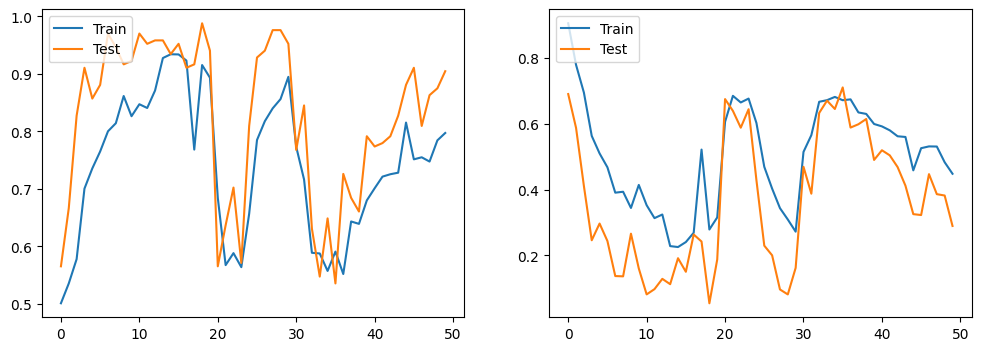

In [ ]:
plot_history(history)

### Soft Attention

In [ ]:
from tensorflow.keras.layers import Layer, Dense, SimpleRNN, Dropout, Activation, Dot
import tensorflow.keras.backend as K

class SoftAttention(Layer):
    def __init__(self):
        super(SoftAttention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(SoftAttention, self).build(input_shape)

    def call(self, x):
        e = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        alpha = K.softmax(e)
        weighted_input = x * K.expand_dims(alpha)
        context_vector = K.sum(weighted_input, axis=1)
        return context_vector

# Define your model
model_with_attention = Sequential([
    SimpleRNN(128, input_shape=(segment_length, 14), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(128, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(128, return_sequences=True),
    Dropout(0.5),
    SoftAttention(),  # Add soft attention layer
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model_with_attention.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_attention = model_with_attention.fit(X_train_augmented, y_train_augmented, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
105/105 [==============================] - 56s 485ms/step - loss: 0.0759 - accuracy: 0.9601 - val_loss: 5.0176e-04 - val_accuracy: 1.0000
Epoch 2/50
105/105 [==============================] - 49s 465ms/step - loss: 1.1446e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 3/50
 62/105 [================>.............] - ETA: 21s - loss: 5.4096e-05 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Import useful packages
import tensorflow as tf


def RNN(Input, max_time, n_input, rnn_size, keep_prob, weights_1, biases_1, weights_2, biases_2):
    '''

    Args:
        Input: The reshaped input EEG signals
        max_time: The unfolded time slice of RNN Model
        n_input: The input signal size at one time
        rnn_size: The number of RNN units inside the RNN Model
        keep_prob: The Keep probability of Dropout
        weights_1: The Weights of first fully-connected layer
        biases_1: The biases of first fully-connected layer
        weights_2: The Weights of second fully-connected layer
        biases_2: The biases of second fully-connected layer

    Returns:
        FC_2: Final prediction of RNN Model
        FC_1: Extracted features from the first fully connected layer

    '''

    # One layer RNN Model
    Input = tf.reshape(Input, [-1, max_time, n_input])
    rnn_cell = tf.keras.layers.SimpleRNN(units=rnn_size)
    rnn_drop = tf.keras.layers.Dropout(rate=1-keep_prob)(rnn_cell(Input)) # Adjust Dropout usage
    outputs, final_state = rnn_drop, rnn_drop[:,-1,:] # Extract final state

    # First fully-connected layer
    FC_1 = tf.matmul(final_state, weights_1) + biases_1
    FC_1 = tf.layers.batch_normalization(FC_1, training=True)
    FC_1 = tf.nn.softplus(FC_1)
    FC_1 = tf.nn.dropout(FC_1, keep_prob)

    # Second fully-connected layer
    FC_2 = tf.matmul(FC_1, weights_2) + biases_2
    FC_2 = tf.nn.softmax(FC_2)

    return FC_2, FC_1


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Import useful packages
import tensorflow as tf


def RNN(Input, max_time, n_input, rnn_size, keep_prob, weights_1, biases_1, weights_2, biases_2):
    '''

    Args:
        Input: The reshaped input EEG signals
        max_time: The unfolded time slice of RNN Model
        n_input: The input signal size at one time
        rnn_size: The number of RNN units inside the RNN Model
        keep_prob: The Keep probability of Dropout
        weights_1: The Weights of first fully-connected layer
        biases_1: The biases of first fully-connected layer
        weights_2: The Weights of second fully-connected layer
        biases_2: The biases of second fully-connected layer

    Returns:
        FC_2: Final prediction of RNN Model
        FC_1: Extracted features from the first fully connected layer

    '''

    # One layer RNN Model
    Input = tf.reshape(Input, [-1, max_time, n_input])
    rnn_cell = tf.keras.layers.SimpleRNN(units=rnn_size, return_sequences=True, return_state=True) # Modified to return sequences and state
    rnn_drop, final_state = rnn_cell(Input) # Extract final state directly
    rnn_drop = tf.keras.layers.Dropout(rate=1-keep_prob)(rnn_drop) # Adjust Dropout usage

    # First fully-connected layer
    FC_1 = tf.matmul(final_state, weights_1) + biases_1
    # Use tf.keras.layers.BatchNormalization instead of tf.layers.batch_normalization
    FC_1 = tf.keras.layers.BatchNormalization()(FC_1)
    FC_1 = tf.nn.softplus(FC_1)
    FC_1 = tf.nn.dropout(FC_1, keep_prob)

    # Second fully-connected layer
    FC_2 = tf.matmul(FC_1, weights_2) + biases_2
    FC_2 = tf.nn.softmax(FC_2)

    return FC_2, FC_1

In [ ]:

# Định nghĩa các tham số cho mạng RNN
max_time = segment_length
n_input = X_train.shape[-1]
rnn_size = 128
keep_prob = 0.5
weights_1 = tf.Variable(tf.random.normal([rnn_size, 256])) # Use tf.random.normal
biases_1 = tf.Variable(tf.random.normal([256])) # Use tf.random.normal
weights_2 = tf.Variable(tf.random.normal([256, 2]))  # Assuming 2 classes for classification # Use tf.random.normal
biases_2 = tf.Variable(tf.random.normal([2])) # Use tf.random.normal

# Định nghĩa inputs và outputs cho mô hình
inputs = Input(shape=(max_time, n_input))
FC_2, FC_1 = RNN(inputs, max_time, n_input, rnn_size, keep_prob, weights_1, biases_1, weights_2, biases_2)

# Biên dịch mô hình
model_8 = Model(inputs=inputs, outputs=FC_2)
model_8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history_8 = model_8.fit(X_train_augmented, y_train_augmented, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
105/105 [==============================] - 17s 114ms/step - loss: 8.6607 - accuracy: 0.5595 - val_loss: 9.2338 - val_accuracy: 0.6250
Epoch 2/50
105/105 [==============================] - 12s 111ms/step - loss: 5.9994 - accuracy: 0.6408 - val_loss: 5.8588 - val_accuracy: 0.6726
Epoch 3/50
105/105 [==============================] - 14s 131ms/step - loss: 7.0677 - accuracy: 0.5988 - val_loss: 10.0268 - val_accuracy: 0.4643
Epoch 4/50
105/105 [==============================] - 12s 118ms/step - loss: 8.7094 - accuracy: 0.5068 - val_loss: 11.6792 - val_accuracy: 0.4107
Epoch 5/50
105/105 [==============================] - 12s 116ms/step - loss: 8.4455 - accuracy: 0.5104 - val_loss: 7.1232 - val_accuracy: 0.5536
Epoch 6/50
105/105 [==============================] - 12s 118ms/step - loss: 8.0804 - accuracy: 0.5140 - val_loss: 9.0871 - val_accuracy: 0.4464
Epoch 7/50
105/105 [==============================] - 12s 117ms/step - loss: 7.7315 - accuracy: 0.5134 - val_loss: 9.3000 - val_